In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse

from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA, TruncatedSVD # Added TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer # Added TfidfVectorizer
from scipy.stats import zscore
from collections import defaultdict

In [45]:
CSV_FILE = "../data/raw/products_with_prices_ingredients_nutrition.csv"
TEXT_COL = "Ingredients"
NUMERIC_COLS = ['Price (USD)', 'Calories', 'Carbs (g)', 'Protein (g)', 'Fat (g)', 'Sugar Added (g)', 'Sugar Natural (g)']
TFIDF_MAX_FEATURES = 10000
TEXT_SVD_COMPONENTS = 50 # Target dimensionality for ingredient features

# --- GMM SWEEP CONFIG ---
K_MIN = 2
K_MAX = 20
COVARIANCE_TYPE = "full"
N_INIT = 3
RANDOM_STATE = 42

In [46]:
def clean_column_names(df):
    """Clean up column names for safe access."""
    new_cols = {}
    for col in df.columns:
        # Create a clean version of the column name
        new_name = col.replace(' (USD)', '_usd').replace(' (g)', '_g').replace(' ', '_').replace('(', '').replace(')', '').lower()
        new_cols[col] = new_name
    return df.rename(columns=new_cols)

In [47]:
def load_data(csv_file):
    """Load data and clean column names."""
    if csv_file:
        df = pd.read_csv(csv_file)
        # Apply cleaning to raw columns
        df = clean_column_names(df)
        
        # Adjust NUMERIC_COLS to the cleaned names for lookup
        numeric_cols_clean = [clean_column_names(pd.DataFrame(columns=[col])).columns[0] for col in NUMERIC_COLS]
        text_col_clean = clean_column_names(pd.DataFrame(columns=[TEXT_COL])).columns[0]
        
        return df, numeric_cols_clean, text_col_clean
    else:
        raise FileNotFoundError(f"CSV file not found at path: {csv_file}")

In [48]:
def build_combined_features(df, numeric_cols, text_col, svd_components):
    """Builds and combines Scaled Numeric features and SVD-reduced Text features."""
    
    # 1. Numeric Feature Processing (Scaling)
    X_num_raw = df[numeric_cols].to_numpy()
    X_num_raw[np.isnan(X_num_raw)] = 0.0
    scaler = StandardScaler()
    X_num_scaled = scaler.fit_transform(X_num_raw)
    
    # 2. Text Feature Processing (TF-IDF + Truncated SVD)
    text_data = df[text_col].fillna('').astype(str)
    
    # a. TF-IDF Vectorization - ERROR FIXED HERE
    # We use ngram_range=(1, 2) to get unigrams and bigrams
    tfidf = TfidfVectorizer(max_features=TFIDF_MAX_FEATURES, stop_words='english', ngram_range=(1, 2))
    X_text_sparse = tfidf.fit_transform(text_data)
    print(f"  TF-IDF sparse shape: {X_text_sparse.shape}")
    
    # b. Truncated SVD (Dimensionality Reduction for sparse data)
    svd = TruncatedSVD(n_components=svd_components, random_state=RANDOM_STATE)
    X_text_reduced = svd.fit_transform(X_text_sparse)
    
    print(f"  SVD reduced shape: {X_text_reduced.shape}")
    
    # 3. Concatenate Features
    X_combined = np.hstack([X_num_scaled, X_text_reduced])
    
    print(f"  Final combined feature shape: {X_combined.shape}")
    
    return X_combined

In [49]:
def gmm_k_sweep(X, k_min, k_max, covariance_type, n_init, random_state):
    """Fit GMM for k in [k_min, k_max] and collect internal metrics."""
    out = []
    for k in range(k_min, k_max + 1):
        try:
            gm = GaussianMixture(
                n_components=k,
                covariance_type=covariance_type,
                random_state=random_state,
                n_init=n_init,
                reg_covar=1e-6
            ).fit(X)
            labels = gm.predict(X)

            bic = gm.bic(X)   
            aic = gm.aic(X)   

            uniq = np.unique(labels)
            if len(uniq) > 1 and len(uniq) < len(X):
                sil = silhouette_score(X, labels)
                db  = davies_bouldin_score(X, labels)
                ch  = calinski_harabasz_score(X, labels)
            else:
                sil, db, ch = np.nan, np.nan, np.nan

            out.append({
                "k": k, "model": gm, "labels": labels,
                "bic": bic, "aic": aic, "silhouette": sil,
                "davies_bouldin": db, "calinski_harabasz": ch
            })
        except ValueError as e:
            print(f"Warning: GMM failed to converge for k={k}. Skipping.")
            out.append({"k": k, "model": None, "labels": None, 
                        "bic": np.nan, "aic": np.nan, "silhouette": np.nan, 
                        "davies_bouldin": np.nan, "calinski_harabasz": np.nan})
            continue

    return out

In [50]:
def suggest_k(results):
    """
    Suggests k based on a meta-score combining z-scored metrics, 
    using .get() to safely handle missing keys.
    """
    df = pd.DataFrame([{
        "k": r.get("k"),
        "bic": r.get("bic", np.nan),
        "aic": r.get("aic", np.nan),
        "sil": r.get("silhouette", np.nan),
        "db":  r.get("davies_bouldin", np.nan),
        "ch":  r.get("calinski_harabasz", np.nan)
    } for r in results if r.get('model') is not None]) 

    if df.empty:
        raise RuntimeError("No models converged successfully to calculate metrics.")

    df_f = df.copy()
    for col in ["sil", "db", "ch", "bic", "aic"]:
        if df_f[col].isna().any():
            df_f[col].fillna(df_f[col].median(), inplace=True)

    z = pd.DataFrame({
        "k": df_f["k"],
        "z_neg_bic":  zscore(-df_f["bic"]),  
        "z_neg_aic":  zscore(-df_f["aic"]),  
        "z_sil":      zscore(df_f["sil"]),
        "z_neg_db":   zscore(-df_f["db"]),   
        "z_ch":       zscore(df_f["ch"])
    })
    
    z["meta"] = z[["z_neg_bic", "z_neg_aic", "z_sil", "z_neg_db", "z_ch"]].sum(axis=1)
    
    z = z.set_index("k")
    k_best = int(z["meta"].idxmax())

    return k_best, df.set_index("k"), z

In [51]:
def plot_metrics(df_by_k, k_best=None):
    """Plotting function for notebook display."""
    ks = df_by_k.index.values

    plt.figure(figsize=(12, 8))

    # BIC / AIC (lower is better)
    plt.subplot(2, 2, 1)
    plt.plot(ks, df_by_k["bic"], marker='o', label="BIC")
    plt.plot(ks, df_by_k["aic"], marker='o', label="AIC", alpha=0.7)
    if k_best: plt.axvline(k_best, linestyle='--', color='gray', label=f'Suggested k={k_best}')
    plt.title("GMM: BIC/AIC vs k (lower is better)"); plt.xlabel("k"); plt.ylabel("Score"); plt.legend()

    # Silhouette (higher better)
    plt.subplot(2, 2, 2)
    plt.plot(ks, df_by_k["silhouette"], marker='o')
    if k_best: plt.axvline(k_best, linestyle='--', color='gray')
    plt.title("Silhouette vs k"); plt.xlabel("k"); plt.ylabel("Silhouette")

    # Davies–Bouldin (lower better)
    plt.subplot(2, 2, 3)
    plt.plot(ks, df_by_k["davies_bouldin"], marker='o')
    if k_best: plt.axvline(k_best, linestyle='--', color='gray')
    plt.title("Davies–Bouldin vs k"); plt.xlabel("k"); plt.ylabel("DB (lower better)")

    # Calinski–Harabasz (higher better)
    plt.subplot(2, 2, 4)
    plt.plot(ks, df_by_k["calinski_harabasz"], marker='o')
    if k_best: plt.axvline(k_best, linestyle='--', color='gray')
    plt.title("Calinski–Harabasz vs k"); plt.xlabel("k"); plt.ylabel("CH (higher better)")

    plt.tight_layout()

In [52]:
def pca_scatter(X, labels, title):
    """2D scatter plot of clusters after PCA."""
    pca = PCA(n_components=2, random_state=42)
    X2 = pca.fit_transform(X)
    plt.figure(figsize=(7,6))
    
    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap('Spectral', len(unique_labels))
    
    for c in unique_labels:
        idx = labels == c
        plt.scatter(X2[idx,0], X2[idx,1], s=14, label=f"Cluster {c}", color=colors(c / len(unique_labels)))
        
    plt.title(title); plt.xlabel("PC1"); plt.ylabel("PC2")
    if len(unique_labels) < 20:
        plt.legend(frameon=False) 
        
    plt.tight_layout()

In [53]:
def notebook_main():
    """Main function adapted for notebook execution."""
    
    print(f"Loading data from: {CSV_FILE}")
    # This call loads the data and returns the CORRECT list of cleaned names
    df, numeric_cols_clean, text_col_clean = load_data(CSV_FILE)
    print(f"Using numeric columns: {numeric_cols_clean}")
    print(f"Using text column: {text_col_clean}")

    # 2) Build combined features
    print("\nBuilding combined features (Scaling numeric + TFIDF/SVD on ingredients)...")
    # FIX IS HERE: Pass the correct 'numeric_cols_clean' list
    X = build_combined_features(df, numeric_cols_clean, text_col_clean, TEXT_SVD_COMPONENTS)

    # 3) Sweep k and collect metrics
    print(f"\nSweeping k from {K_MIN} to {K_MAX}...")
    results = gmm_k_sweep(
        X,
        k_min=K_MIN,
        k_max=K_MAX,
        covariance_type=COVARIANCE_TYPE,
        n_init=N_INIT,
        random_state=RANDOM_STATE
    )
    
    results_ok = [r for r in results if r.get('model') is not None]

    # 4) Summaries + suggested k
    try:
        k_best, raw_table, z_table = suggest_k(results_ok)
    except RuntimeError as e:
        print(f"\nFATAL ERROR: {e}")
        return

    # Print results
    print("\n" + "="*20 + " Metrics by k " + "="*20)
    print(raw_table.round(4).to_string())
    print("\n" + "="*12 + " Z-scored (combined) meta-scores " + "="*12)
    print(z_table.round(3).to_string())
    print(f"\nHeuristic suggested k: {k_best}")

    # 5) Plots
    plot_metrics(raw_table, k_best=k_best)

    # 6) Final model
    best_model = next(r["model"] for r in results_ok if r["k"] == k_best)
    labels = best_model.predict(X)
    print(f"\nFinal GMM: k={k_best}, covariance_type={COVARIANCE_TYPE}")
    unique, counts = np.unique(labels, return_counts=True)
    
    cluster_sizes = pd.DataFrame({'Cluster ID': unique, 'Size': counts}).sort_values('Size', ascending=False)
    print("\nCluster sizes:")
    print(cluster_sizes.to_markdown(index=False))

    pca_scatter(X, labels, title=f"GMM (k={k_best}) — PCA 2D view")

Loading data from: ../data/raw/products_with_prices_ingredients_nutrition.csv
Using numeric columns: ['price_usd', 'calories', 'carbs_g', 'protein_g', 'fat_g', 'sugar_added_g', 'sugar_natural_g']
Using text column: ingredients

Building combined features (Scaling numeric + TFIDF/SVD on ingredients)...
  TF-IDF sparse shape: (49688, 2200)
  SVD reduced shape: (49688, 50)
  Final combined feature shape: (49688, 57)

Sweeping k from 2 to 20...

==================== Metrics by k ====================
             bic           aic     sil      db          ch
k                                                         
2  -7.277959e+06 -7.308110e+06  0.4325  1.5713  10262.3127
3  -7.729967e+06 -7.775198e+06  0.3923  1.1340  10816.8004
4  -1.042175e+07 -1.048206e+07  0.3987  1.4085  12160.9545
5  -1.133469e+07 -1.141008e+07  0.3265  1.7759  12744.7759
6  -1.296860e+07 -1.305907e+07  0.4162  1.1909  16487.5291
7  -1.338154e+07 -1.348709e+07  0.4170  1.0939  20051.4257
8  -1.343111e+07 -1.355174e

KeyError: 'silhouette'

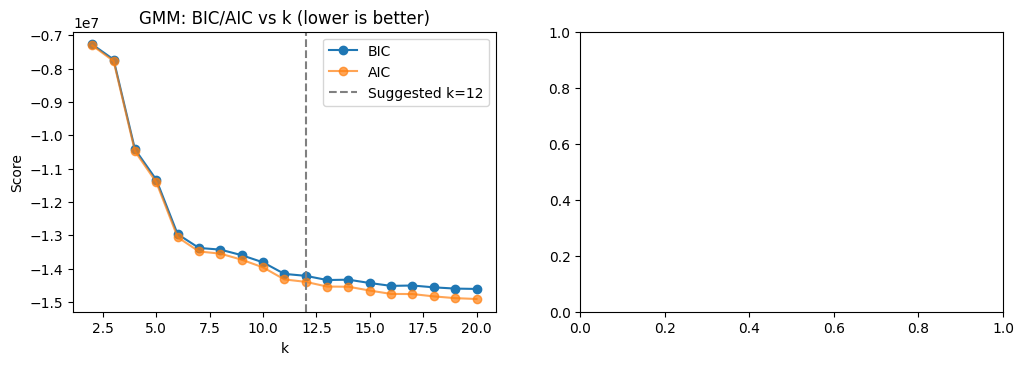

In [54]:
notebook_main()